In [33]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model

In [34]:
data = pd.read_csv("/Users/liza/Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv")
data.head()
data_ = data.copy()

In [35]:
data.shape

(1470, 35)

In [36]:
for uniqu in data.columns:
    print(f"{uniqu:15}{data[uniqu].unique()}\n")

Age            [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]

Attrition      ['Yes' 'No']

BusinessTravel ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

DailyRate      [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  594  470  957  542  802 1355 1150 1329  959 1033 1316  364  438  689
  201 1427  857  933 1181 1395 

In [37]:
data.columns[data.isnull().sum() != 0]

Index([], dtype='object')

В наших данных нет пропущенных значений.

In [38]:
categorical_columns = data.columns[data.dtypes == 'object']
num_columns = data.columns[data.dtypes == 'float64'].union(data.columns[data.dtypes == 'int64'])
len(categorical_columns), len(num_columns)

(9, 26)

Таким образом, в наших данных 8 категориальных признаков и 26 числовых. 

In [363]:
df = pd.DataFrame(data=data.nunique(), columns=['nunique'], dtype=int) # nunique - уникальные значения
df['nunique(%)'] = data.nunique()/len(data) * 100 

df['pass'] = data.isnull().sum() # pass - пропуски

for column in categorical_columns:
    df['median'] = None
    df['std'] = None
    df['min'] = None
    df['max'] = None
    

df['mean'] = data[num_columns].mean()
df['std'] = data[num_columns].std()
df['min'] = data[num_columns].min()
df['max'] = data[num_columns].max()
df['type'] = data.dtypes
df.head()


,nunique,nunique(%),pass,median,std,min,max,mean,type
Age,43,2.925170,0,None,9.135373,18.0,60.0,36.923810,int64
Attrition,2,0.136054,0,None,NaN,NaN,NaN,NaN,object
BusinessTravel,3,0.204082,0,None,NaN,NaN,NaN,NaN,object
DailyRate,886,60.272109,0,None,403.509100,102.0,1499.0,802.485714,int64
Department,3,0.204082,0,None,NaN,NaN,NaN,NaN,object


 Q-Q график. Для нормального распределения он будет выглядеть как ровная диагональная линия, и визуальные отклонения интуитивно понятны.

Удалим три константных признака, они не имеют никакой важности для построения модели. 

In [40]:
data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1, inplace=True)

In [41]:
num_columns = num_columns.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours'])

Теперь разберемся с EmployeeNumber. Судя по всему это уникальный номер каждого сотрудника (повторений нет и не может быть), можно заменить этот столбец на столбец индексов. 

In [42]:
data = data.set_index('EmployeeNumber')

In [43]:
 data.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


При подготовке данных для моделей машинного обучения необходимо проанализировать все выбросы 

Займемся поиском аномальных значений в данных (выбросов). Так как большинство признаков далеки от нормального распределения, воспользуемся методом IQR. 
IQR вычисляется, как разница между 75 и 25 перцентилями 
бла бла бла бла (ящики с усами)

In [362]:
import numpy as np 

for num_col in num_columns:
    q25, q75 = np.percentile(data[num_col], 25), np.percentile(data[num_col], 75)
    iqr = q75 - q25
    
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    outliers = [x for x in data[num_col] if x < lower or x > upper]
    
    
    if len(outliers) != 0:
        
        print(num_col)
        print(lower, upper)
        print(outliers)
    
    
    #print(num_col, iqr)

MonthlyIncome
-5291.0 16581.0
[19094, 18947, 19545, 18740, 18844, 18172, 17328, 16959, 19537, 17181, 19926, 19033, 18722, 19999, 16792, 19232, 19517, 19068, 19202, 19436, 16872, 19045, 19144, 17584, 18665, 17068, 19272, 18300, 16659, 19406, 19197, 19566, 18041, 17046, 17861, 16835, 16595, 19502, 18200, 16627, 19513, 19141, 19189, 16856, 19859, 18430, 17639, 16752, 19246, 17159, 17924, 17099, 17444, 17399, 19419, 18303, 19973, 19845, 17650, 19237, 19627, 16756, 17665, 16885, 17465, 19626, 19943, 18606, 17048, 17856, 19081, 17779, 19740, 18711, 18265, 18213, 18824, 18789, 19847, 19190, 18061, 17123, 16880, 17861, 19187, 19717, 16799, 17328, 19701, 17169, 16598, 17007, 16606, 19586, 19331, 19613, 17567, 19049, 19658, 17426, 17603, 16704, 19833, 19038, 19328, 19392, 19665, 16823, 17174, 17875, 19161, 19636, 19431, 18880]
NumCompaniesWorked
-3.5 8.5
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9

PerformanceRating, StockOptionLevel - это закодированные признаки one hot так что можно не рассматривать их как выбросы. 

стандартное значение k - фактора = 1.5

In [354]:
q25, q75 = np.percentile(data['YearsAtCompany'], 25), np.percentile(data['YearsAtCompany'], 75)
iqr = q75 - q25
iqr

6.0

In [355]:
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
lower, upper

(-6.0, 18.0)

In [356]:
outliers = [x for x in data['YearsAtCompany'] if x < lower or x > upper]

data.loc[data['YearsAtCompany'].isin(outliers)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
23,53,No,Travel_Rarely,1219,Sales,2,4,Life Sciences,1,Female,...,3,3,0,31,3,3,25,8,3,7
36,44,No,Travel_Rarely,477,Research & Development,7,4,Medical,1,Female,...,3,4,1,24,4,3,22,6,5,17
58,41,Yes,Travel_Rarely,1360,Research & Development,12,3,Technical Degree,2,Female,...,3,4,0,23,0,3,22,15,15,8
80,50,No,Travel_Rarely,989,Research & Development,7,2,Medical,2,Female,...,3,4,1,29,2,2,27,3,13,8
81,59,No,Travel_Rarely,1435,Sales,25,3,Life Sciences,1,Female,...,3,4,0,28,3,2,21,16,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,39,No,Travel_Rarely,119,Sales,15,4,Marketing,2,Male,...,3,1,0,21,3,3,20,8,11,10
1976,42,No,Non-Travel,335,Research & Development,23,2,Life Sciences,4,Male,...,3,4,0,20,2,3,20,9,3,7
2031,42,No,Travel_Rarely,300,Research & Development,2,3,Life Sciences,1,Male,...,3,1,0,24,2,2,22,6,4,14


In [358]:
diff = data['Age'] - data['YearsAtCompany'] 
data.loc[(data['YearsAtCompany'].isin(outliers))  & (diff < 18)]


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,


In [359]:
outliers_removed = [x for x in data['YearsAtCompany'] if x > lower and x < upper]
len(outliers_removed)

1353

In [360]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [51]:
data.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [339]:
data.groupby('Attrition').describe()

Age                                                   DailyRate  \
            count       mean      std   min   25%   50%   75%   max     count   
Attrition                                                                       
No         1233.0  37.561233  8.88836  18.0  31.0  36.0  43.0  60.0    1233.0   
Yes         237.0  33.607595  9.68935  18.0  28.0  32.0  39.0  58.0     237.0   

                       ... YearsSinceLastPromotion       YearsWithCurrManager  \
                 mean  ...                     75%   max                count   
Attrition              ...                                                      
No         812.504461  ...                     3.0  15.0               1233.0   
Yes        750.362869  ...                     2.0  15.0                237.0   

                                                         
               mean       std  min  25%  50%  75%   max  
Attrition                                                
No         4.367397  3.594116  0.0  2.0  3.0  7.0  17.0  
Yes        2.852321  3.143349  0.0  0.0  2.0  5.0  14.0  

[2 rows x 184 columns]

In [53]:
data.Attrition.value_counts(normalize=True)

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

Данные не являются сбалансированными относительно целевой переменной. Покажем это с помощью графиков.

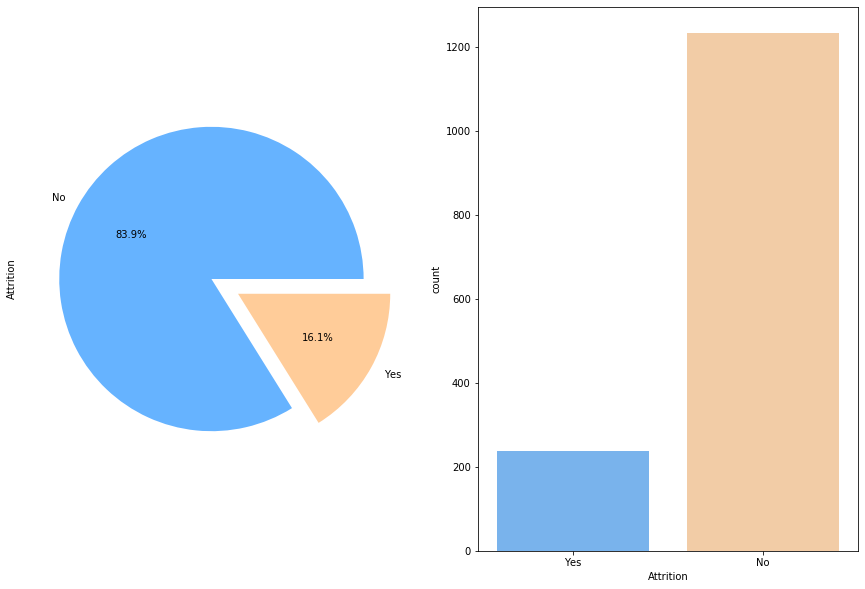

In [340]:
colors = ['#66b3ff','#ffcc99']

f,ax = plt.subplots(1,2, figsize=(15,10))
data.Attrition.value_counts().plot.pie(explode=[0,0.20], colors = colors, autopct='%1.1f%%',ax=ax[0])
sns.countplot('Attrition',data=data, palette = colors)
plt.show()

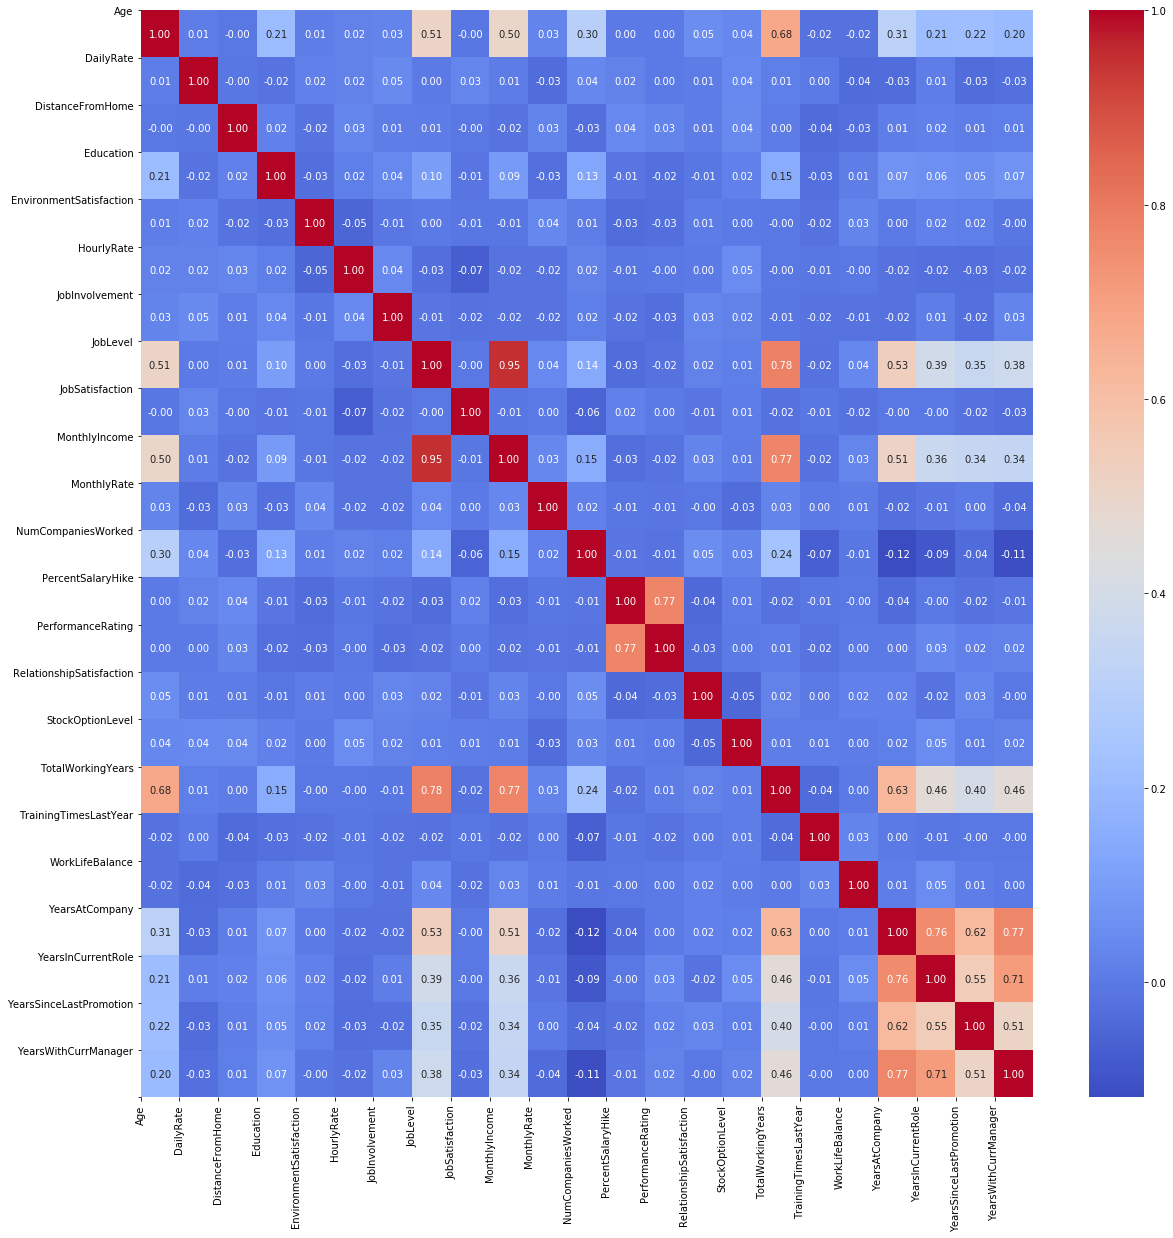

In [341]:
corr = data[num_columns].corr()

fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")

plt.xticks(range(len(corr.columns)), corr.columns)

plt.yticks(range(len(corr.columns) + 1), corr.columns)

plt.show()

In [342]:
data.corr()[lambda x: x > 0.7].head(5)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DailyRate,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EnvironmentSatisfaction,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Обратим внимание на наиболее коррелирующие признаки:
TotalWorkingYears и JobLevel, MonthlyIncome и JobLevel, MonthlyIncome и TotalWorkingYears, PercentSalaryHike и PerformanceRating, YearsInCurrentRole и YearsAtCompany, YearsWithCurrManager и YearsAtCompany, YearsWithCurrManager и YearsInCurrentRole плюс можно еще отнести Age и TotalWorkingYears (~ 0.7)

Рассмотрим распределения последних 15 признаков.

In [57]:
data.columns[15:]

Index(['MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [59]:
data['MonthlyIncome'].value_counts()

2342     4
5562     3
2741     3
2451     3
2610     3
        ..
5381     1
13577    1
12965    1
3339     1
14336    1
Name: MonthlyIncome, Length: 1349, dtype: int64

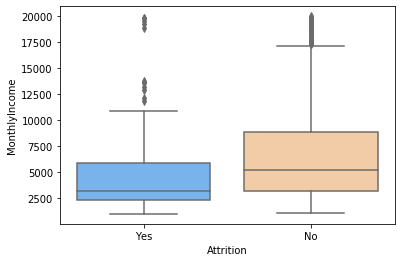

In [361]:
sns.boxplot(x='Attrition', y='MonthlyIncome', data=data, palette = colors)

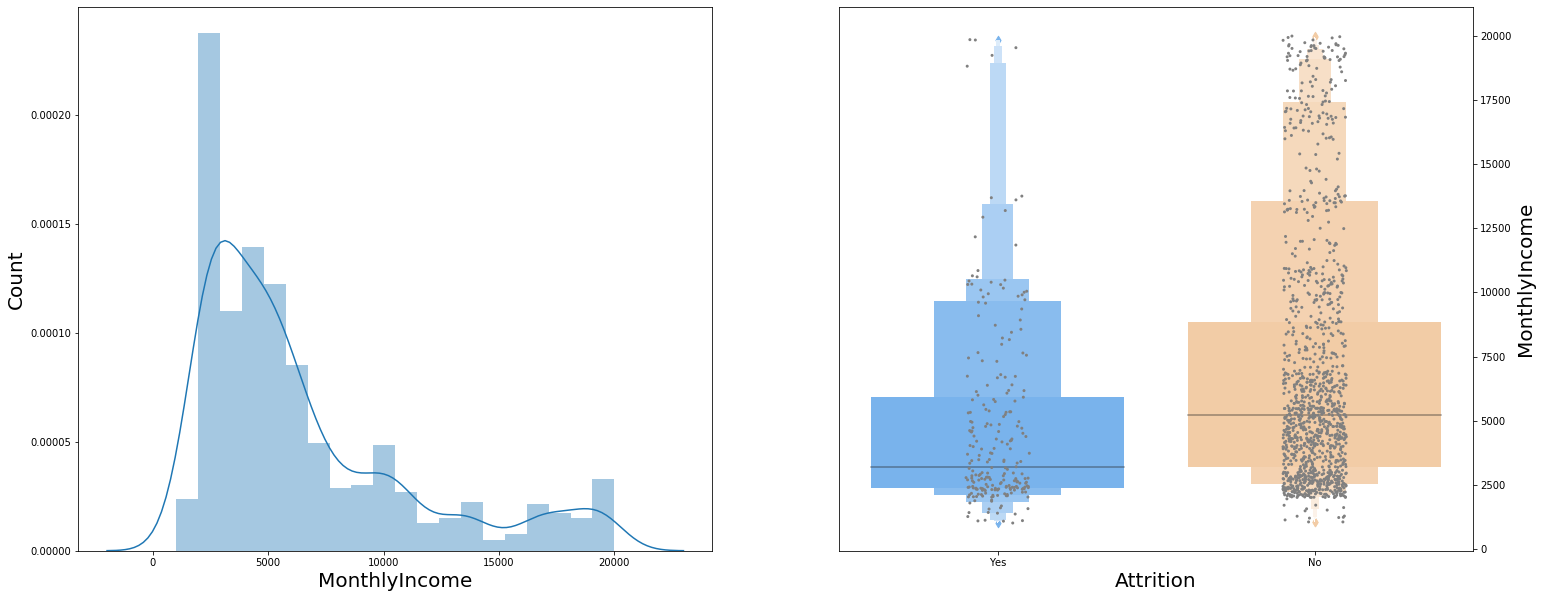

In [344]:
f, axes = plt.subplots(1, 2, figsize=(25,10))

sns.distplot(data['MonthlyIncome'], ax = axes[0])
axes[0].set_xlabel('MonthlyIncome', fontsize = 20)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].yaxis.tick_left()

ax = sns.boxenplot(x = 'Attrition', y = 'MonthlyIncome', data = data, palette= colors,  ax = axes[1])
ax = sns.stripplot(x = "Attrition", y = "MonthlyIncome", data=data, color="gray", size = 3)
axes[1].set_xlabel('Attrition', fontsize = 20)
axes[1].set_ylabel('MonthlyIncome', fontsize = 20)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()


Попробуем убрать часть хвоста в распределении (значения, которые входят в аномальные). Порог - (-5291.0 16581.0) 

In [345]:
data.groupby('Attrition').JobLevel.value_counts(normalize=True)

Attrition  JobLevel
No         2           0.390916
           1           0.324412
           3           0.150852
           4           0.081914
           5           0.051906
Yes        1           0.603376
           2           0.219409
           3           0.135021
           4           0.021097
           5           0.021097
Name: JobLevel, dtype: float64

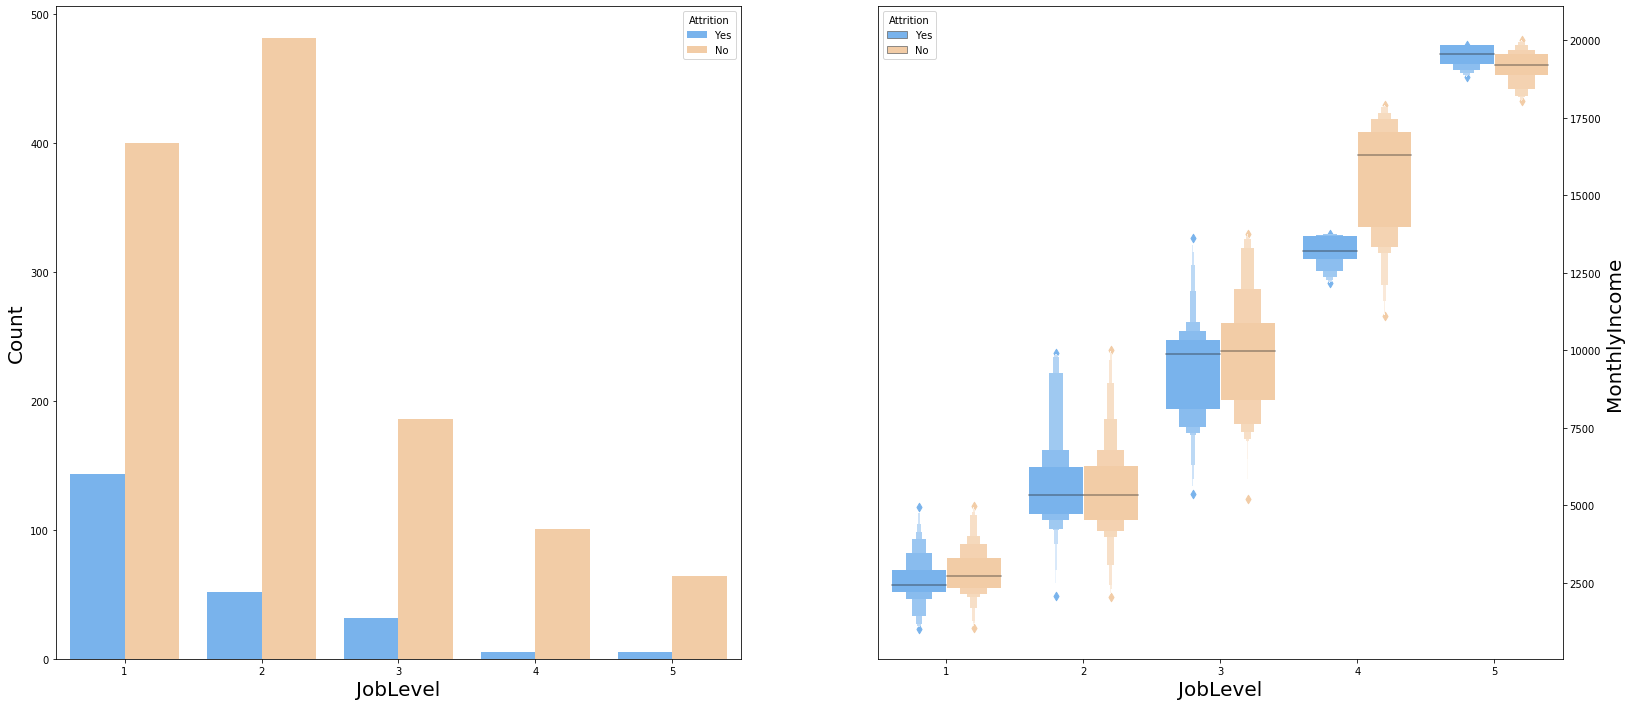

In [346]:
f, axes = plt.subplots(1, 2, figsize=(27,12))

f = sns.countplot('JobLevel',data=data, palette=colors, hue = 'Attrition', ax = axes[0])
axes[0].set_xlabel('JobLevel', fontsize = 20)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].yaxis.tick_left()


ax = sns.boxenplot(x = 'JobLevel', y = 'MonthlyIncome', data = data, hue = 'Attrition', palette=colors, ax = axes[1])
#ax = sns.stripplot(x = "JobLevel", y = "MonthlyIncome", data=data, color="gray", size = 3)
axes[1].set_xlabel('JobLevel', fontsize = 20)
axes[1].set_ylabel('MonthlyIncome', fontsize = 20)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()


plt.show()

Т.е чем выше JobLevel, тем выше MonthlyIncome. Среди выбывших почти 40% имеют JobLevel = 2 b и 32% JobLevel = 1.

In [347]:
data.PerformanceRating.value_counts()

3    1244
4     226
Name: PerformanceRating, dtype: int64

PerformanceRating (рейтинг производительности):
1. 'Low'
2. 'Good'
3. 'Excellent'
4. ‘Outstanding'

In [348]:
 data[data.Attrition == 'No'].PerformanceRating.value_counts()

3    1044
4     189
Name: PerformanceRating, dtype: int64

In [349]:
 data[data.Attrition == 'Yes'].PerformanceRating.value_counts()

3    200
4     37
Name: PerformanceRating, dtype: int64

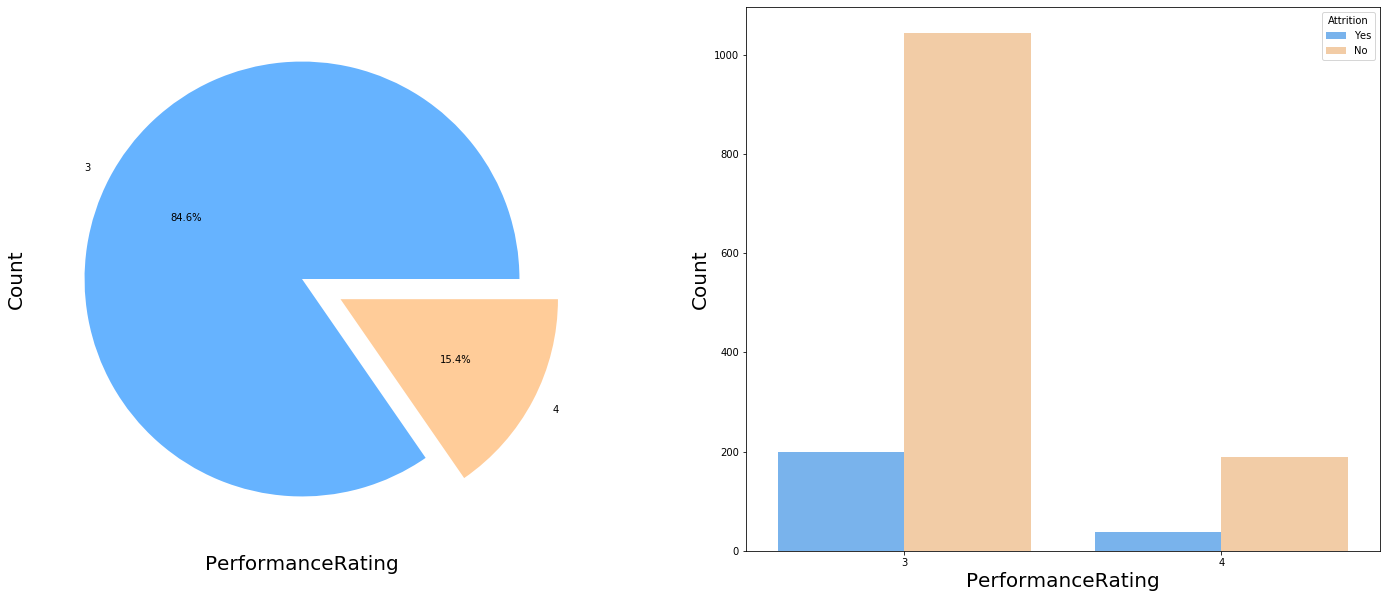

In [350]:
f, axes = plt.subplots(1, 2, figsize=(25,10))

f = data.PerformanceRating.value_counts().plot.pie(explode=[0,0.20], colors=colors, autopct='%1.1f%%',  ax=axes[0])
axes[0].set_xlabel('PerformanceRating', fontsize = 20)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].yaxis.tick_left()


ax = sns.countplot('PerformanceRating',data=data, palette=colors, hue = 'Attrition', ax = axes[1])
axes[1].set_xlabel('PerformanceRating', fontsize = 20)
axes[1].set_ylabel('Count', fontsize=20)
axes[1].yaxis.tick_left()


plt.show()

В наших данных рейтинг производительности у всех сотрудников 'Excellent' или 'Outstanding'. А процентное соотношение 'Excellent' и 'Outstanding' среди действующих и выбывших сотрудников одинаково (около 15% с максимальным рейтингом).

In [351]:
data.TotalWorkingYears.unique()

array([ 8, 10,  7,  6, 12,  1, 17,  5,  3, 31, 13,  0, 26, 24, 22,  9, 19,
        2, 23, 14, 15,  4, 29, 28, 21, 25, 20, 11, 16, 37, 38, 30, 40, 18,
       36, 34, 32, 33, 35, 27])

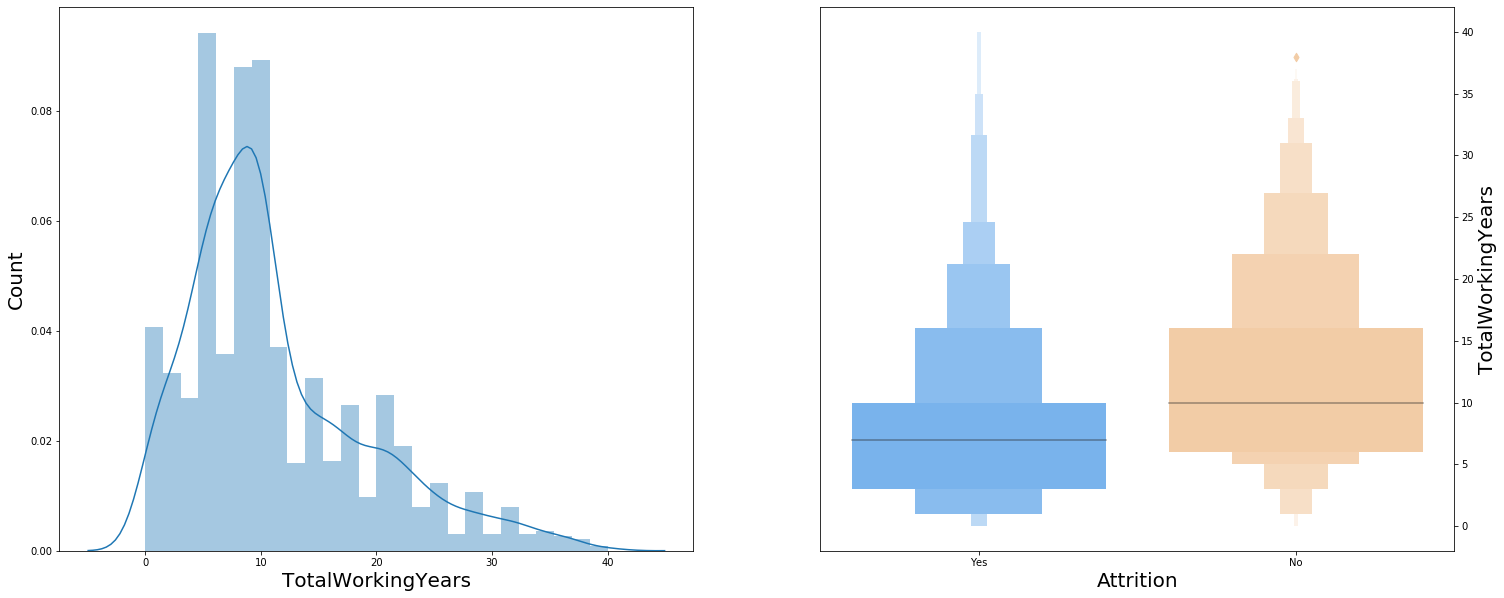

In [352]:
f, axes = plt.subplots(1, 2, figsize=(25,10))

sns.distplot(data['TotalWorkingYears'], ax = axes[0])
axes[0].set_xlabel('TotalWorkingYears', fontsize = 20)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].yaxis.tick_left()

ax = sns.boxenplot(x = 'Attrition', y = 'TotalWorkingYears', data = data, palette= colors,  ax = axes[1])
#ax = sns.stripplot(x = "Attrition", y = "TotalWorkingYears", data=data, color="gray", size = 3)
axes[1].set_xlabel('Attrition', fontsize = 20)
axes[1].set_ylabel('TotalWorkingYears', fontsize = 20)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()

plt.show()

In [289]:
columns = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'JobLevel', 'Attrition']

pairplot показывает отношения между всеми парами переменных. Рассмотрим те признаки, которые имеют среднюю корреляцию (~0.5)

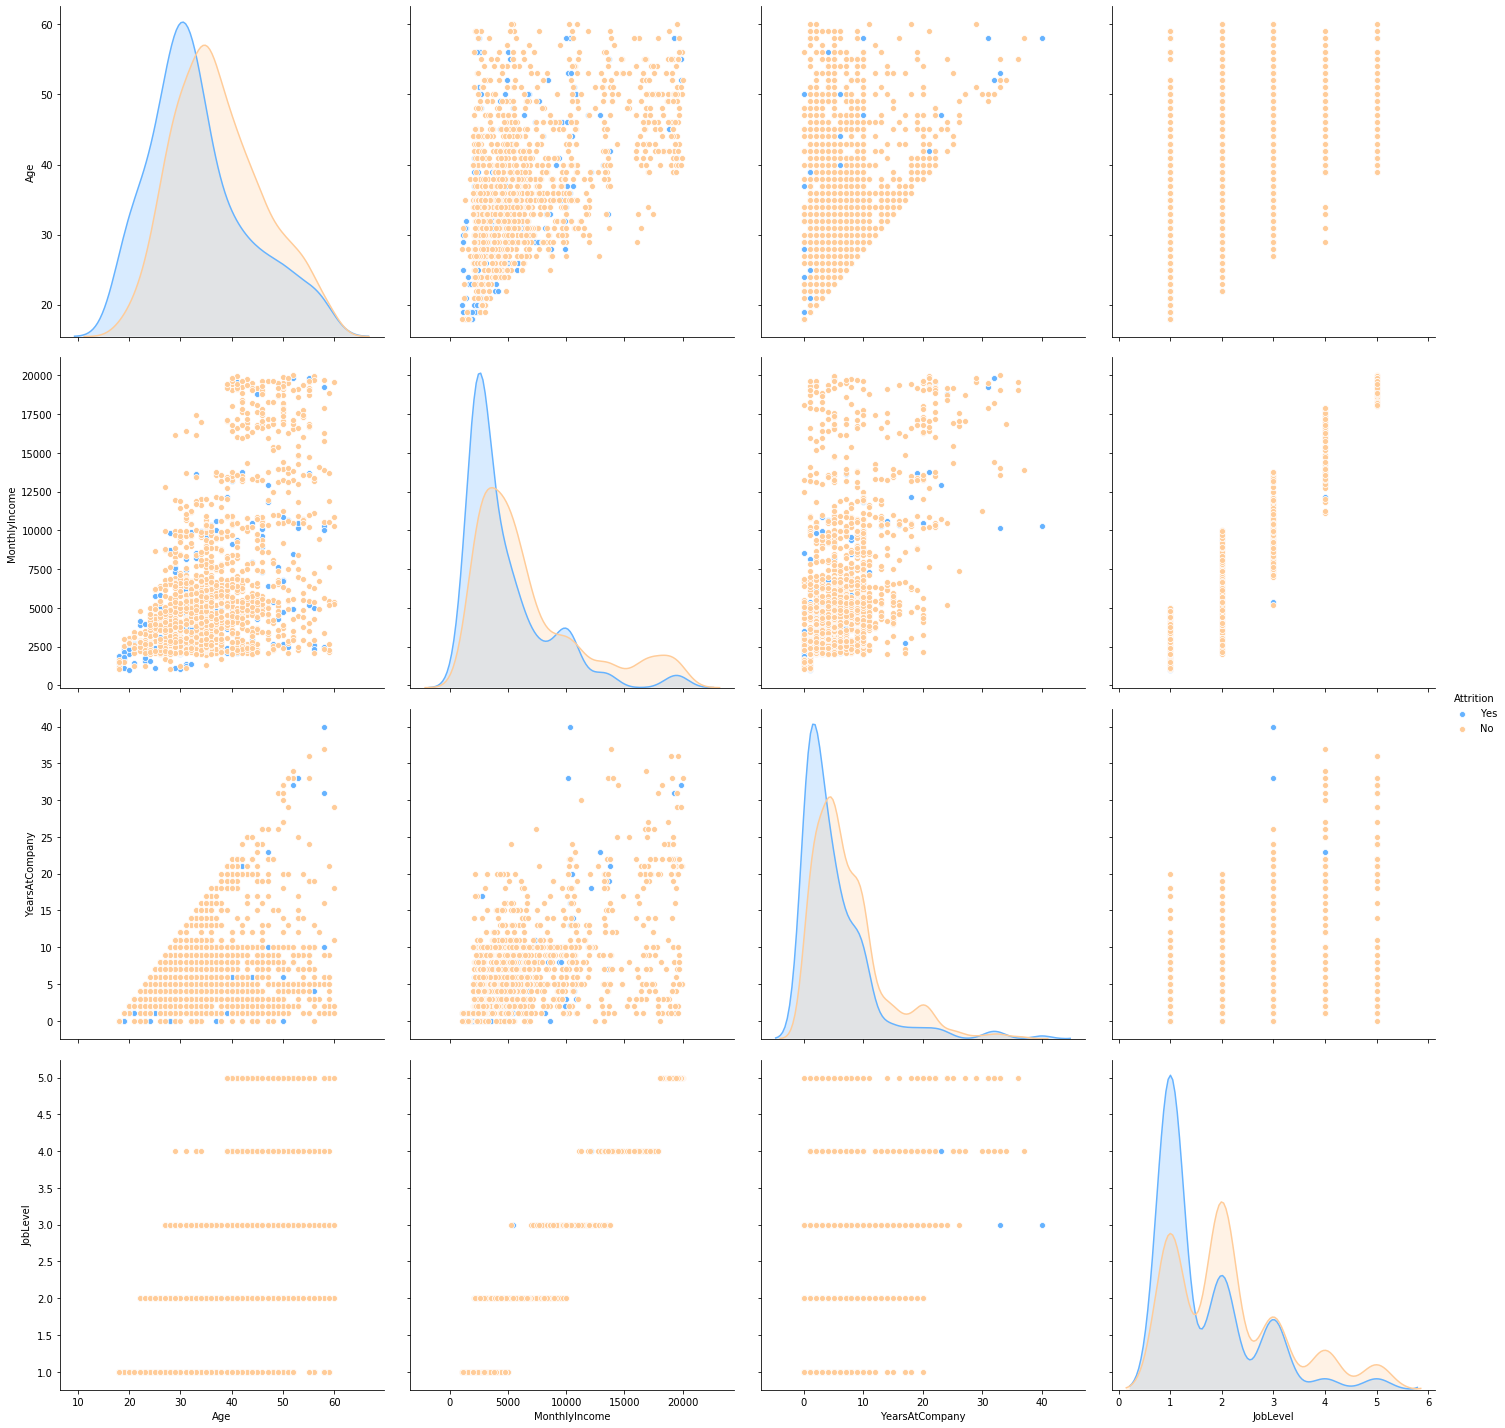

In [325]:
sns.pairplot(data[columns], height = 5, hue = 'Attrition', kind="scatter", palette=colors)

Закономерности:
1. Чем больше возраст, тем выше месячный доход (почти нет тех, кто до 40 получает высокую зарплату) 
2. Чем выше уровень занимаемой должности, тем выше месячный доход. 
Исходя из этого, как факт никто не достигает уровня занимаемой должности 4-5 в возрасте до 30 лет (5 - только после 40).
Но также и нет сотрудников, которые после 20 лет в компании имеют уровень занимаемой должности - 1 и 2. 

3. В основном, сотрудники, которые проработали больше 25 лет в компании, имеют месячный доход выше среднего. Соответственно, если сотрудник в компании больше 20 лет, то уровень занимаемой должности больше 3 (не считая уволенных сотрудников, которые проработали в компании 30 и 40 лет). 


In [324]:
data.loc[(data.Attrition == 'Yes') & (data.JobLevel == 3) & (data.YearsAtCompany > 30)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
165,58,Yes,Travel_Rarely,147,Research & Development,23,4,Medical,4,Female,...,3,4,1,40,3,2,40,10,15,6
1572,53,Yes,Travel_Rarely,607,Research & Development,2,5,Technical Degree,3,Female,...,3,2,1,34,4,3,33,7,1,9


In [278]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [ ]:
data_target = data.Attrition
data.drop(['Attrition'], axis = 1, inplace=True)

In [127]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,data_target,test_size = 0.2,random_state=42)